# Continual Learning Pre - Flight Test Methods :  Sequential Learning

## Necessary Installs

In [1]:
!pip install -q monai einops

## Necessary Imports

In [2]:
# imports and installs
import torch
import torch.nn as nn
import torch.nn.functional as F
import nibabel as nib
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torch.optim import SGD, Adam, ASGD

import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import monai
from monai.transforms import (ScaleIntensityRange, Compose, AddChannel, RandSpatialCrop, ToTensor, 
                            RandAxisFlip, Activations, AsDiscrete, Resize, RandRotate, RandFlip, EnsureType,
                             KeepLargestConnectedComponent)
from monai.metrics import DiceMetric, HausdorffDistanceMetric
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss, FocalLoss, GeneralizedDiceLoss, DiceCELoss, DiceFocalLoss
from monai.networks.nets import UNet, VNet, UNETR, SwinUNETR, AttentionUnet
from monai.data import decollate_batch, ImageDataset
from monai.utils import set_determinism
import os
import wandb
from time import time
from einops import rearrange
from einops.layers.torch import Rearrange
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingLR
from random import sample

torch.manual_seed(2000)
set_determinism(seed=2000)

wandb_log = True

## Create Data Loader 

In [3]:
# Write down the steps for sequential learning

# Task execution 

# Method 1 - Vannila Sequential
# 1. Train on Promise12 --> Test on Promise12
# 2. Train on ISBI --> Test on Promise12, ISBI
# 3. Train on Decathlon --> Test on Promise12, ISBI, Decathlon

# Method 2 - Accumulated learning
# 1. Train on Promise12 --> Test on Promise12
# 2. Train on Promise12, ISBI --> Test on Promise12, ISBI
# 3. Train on Promise12, ISBI, Decathlon --> Test on Promise12, ISBI, Decathlon


# Requirements
# 1. Have train loader & test loader fucntions for each dataset


# Steps
# 1. Get the train & test loader
# 2. Train and test for n epochs


In [4]:
def get_img_label_folds(img_paths, label_paths):
    
    fold = list(range(0,len(img_paths)))
    fold = sample(fold, k=len(fold))
    fold_imgs = [img_paths[i] for i in fold]
    fold_labels = [label_paths[i] for i in fold]
    return fold_imgs, fold_labels

# Transforms for images & labels
train_roi_size = 160
transforms_map = {
        "train_img_transform" : [
            AddChannel(),
            RandSpatialCrop(roi_size= train_roi_size, random_center = True, random_size=False),
            ToTensor()
            ],
        "train_label_transform" : [
            AddChannel(),
            RandSpatialCrop(roi_size= train_roi_size, random_center = True, random_size=False),
            AsDiscrete(threshold=0.5),
            ToTensor()
            ],
        "test_img_transform" : [
            AddChannel(),
            ToTensor()
            ],
        "test_label_transform" : [
            AddChannel(),
            AsDiscrete(threshold=0.5),
            ToTensor()
            ],
    }

# 1. Image & Label paths

dataset_map = {
        "promise12" : {
            "data_dir" : "../input/promise12prostatealigned/",
            "test_size" : 0.1,
            'test' :  {'images' : [], 'labels' : []},
            'train' :  {'images' : [], 'labels' : []}
            
            },
        "decathlon" : {
            "data_dir" : "../input/decathlonprostatealigned/",
            "test_size" : 0.2,
            'test' :  {'images' : [], 'labels' : []},
            'train' :  {'images' : [], 'labels' : []}
            },
        "isbi" : {
            "data_dir" : "../input/isbiprostatealigned/",
            "test_size" : 0.2,
            'test' :  {'images' : [], 'labels' : []},
            'train' :  {'images' : [], 'labels' : []}
            }
    }


for dataset in dataset_map:
    data_dir = dataset_map[dataset]['data_dir']

    img_paths = glob(data_dir + "imagesTr/*.nii")
    label_paths = glob(data_dir + "labelsTr/*.nii")
    img_paths.sort()
    label_paths.sort()
    
    # 2. Folds

    images_fold, labels_fold  = get_img_label_folds(img_paths, label_paths)
    
    print("Number of images: {}".format(len(images_fold)))
    print("Number of labels: {}".format(len(labels_fold)))
    
    # Get train and test sets
    # 3. Split into train - test
    train_idx = int(len(images_fold) * (1 - dataset_map[dataset]['test_size']))
    
    # Store train & test sets 
    
    dataset_map[dataset]['train']['images'] = images_fold[:train_idx]
    dataset_map[dataset]['train']['labels'] = labels_fold[:train_idx]
    
    dataset_map[dataset]['test']['images'] = images_fold[train_idx:]
    dataset_map[dataset]['test']['labels'] = labels_fold[train_idx:]
     

dataloaders_map = {
    'promise12' : {
        'train' : None,
        'test' : None,
    },
    'isbi' : {
        'train' : None,
        'test' : None,
    },
    'decathlon' : {
        'train' : None,
        'test' : None,
    },
}
    
# 5. Image dataset
batch_size = 1
for dataset in dataloaders_map:
    for ttset in dataloaders_map[dataset]:
        
        dset = ImageDataset(dataset_map[dataset][ttset]['images'], dataset_map[dataset][ttset]['labels'],
                            transform=Compose(transforms_map[f'{ttset}_img_transform']), 
                            seg_transform=Compose(transforms_map[f'{ttset}_label_transform']))
        
        dataloaders_map[dataset][ttset] = DataLoader(dset, batch_size=batch_size, shuffle=True)
        

# 6. Get train loader & 3 test loaders

print('-'*100)
for dataset in dataloaders_map:
    for ttset in dataloaders_map[dataset]:
        print(f"No of samples in {dataset}-{ttset} : {len(dataloaders_map[dataset][ttset])}")

# 7. That's it

Number of images: 50
Number of labels: 50
Number of images: 32
Number of labels: 32
Number of images: 79
Number of labels: 79
----------------------------------------------------------------------------------------------------
No of samples in promise12-train : 45
No of samples in promise12-test : 5
No of samples in isbi-train : 63
No of samples in isbi-test : 16
No of samples in decathlon-train : 25
No of samples in decathlon-test : 7


## Visualize dataset


Image shape : torch.Size([28, 1, 160, 160])
Label shape : torch.Size([28, 1, 160, 160])


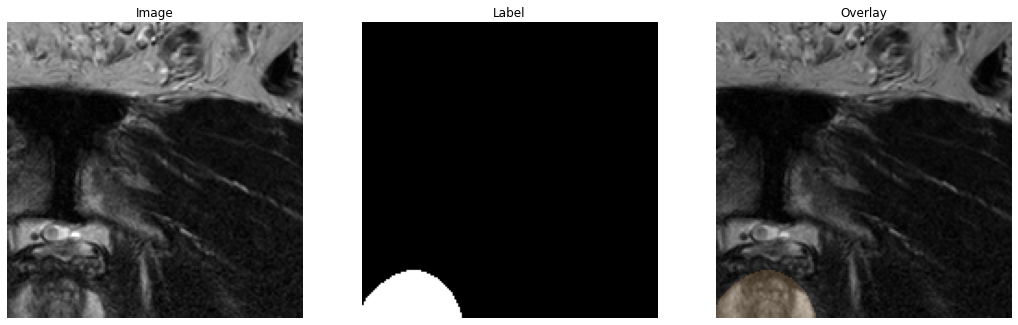

In [5]:
# ----------------------------Get dataloaders--------------------------
imgs,labels = next(iter(dataloaders_map['promise12']['train']))
imgs = rearrange(imgs, 'b c h w d -> (b d) c h w')
labels = rearrange(labels, 'b c h w d -> (b d) c h w')
print(f"\nImage shape : {imgs.shape}")
print(f"Label shape : {labels.shape}")

img_no = 8
plt.figure(figsize=(6*3,6*1))
plt.subplot(1,3,1)
plt.imshow(imgs[img_no,0], cmap='gray')
plt.axis('off')
plt.title('Image')
plt.subplot(1,3,2)
plt.imshow(labels[img_no,0], cmap='gray')
plt.axis('off')
plt.title('Label')
plt.subplot(1,3,3)
plt.imshow(imgs[img_no,0], cmap='gray')
plt.imshow(labels[img_no,0], 'copper', alpha=0.2)
plt.axis('off')
plt.title('Overlay')
plt.show()

### Train - Test Statistics

In [6]:
# print(f"\nTraining samples : {len(train_loader)}")
# # print(f"Testing samples : {len(test_loader)}")

# # -----------------------Slices-----------------------------

# plt.figure(figsize = (1*7, 1*7))

# slices = [label.shape[4] for _, label in train_loader]

# # plt.subplot(1,2,1)
# plt.hist(slices, )
# plt.xlabel('Slices')
# plt.ylabel('Count')
# plt.title('Training Set')

# # slices = [label.shape[4] for _, label in test_loader]
# # plt.subplot(1,2,2)
# # plt.hist(slices, )
# # plt.xlabel('Slices')
# # plt.ylabel('Count')
# # plt.title('Testing set')

# plt.suptitle('Slices in Training & Testing Sets')
# plt.show()

## Train Config, Loss, Metrics

In [7]:
# ----------------------------Train Config-----------------------------------------
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

model = UNet(
        spatial_dims=2,
        in_channels=1,
        out_channels=2,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    ).to(device)

epochs = 100
initial_lr = 1e-3
optimizer = Adam(model.parameters(), lr=initial_lr, weight_decay=1e-5)
# optimizer = ASGD(model.parameters(), lr=initial_lr)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs, verbose=True)
# scheduler = ExponentialLR(optimizer, gamma=0.98)
dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
hd_metric = HausdorffDistanceMetric(include_background=False, percentile = 95.)


# post_trans = Compose([ToTensor(), Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
post_pred = Compose([
    EnsureType(), AsDiscrete(argmax=True, to_onehot=2),
    KeepLargestConnectedComponent(applied_labels=[1], is_onehot=True, connectivity=2)
])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=2)])
argmax = AsDiscrete(argmax=True)
# dice_loss = DiceLoss(to_onehot_y=True, softmax=True)
# bce_loss = nn.BCEWithLogitsLoss()
# ce_loss = nn.CrossEntropyLoss(weight = torch.tensor([1., 20.], device = device))
# focal_loss = FocalLoss(to_onehot_y = True, weight = [.5, 95.])
dice_ce_loss = DiceCELoss(to_onehot_y=True, softmax=True,)
# dice_focal_loss = DiceFocalLoss(to_onehot_y=True, softmax=True, focal_weight = torch.tensor([1., 5.], device = device))
# focal_weight = torch.tensor([1., 20.], device = device)
# weight = torch.tensor([1., 5.], device = device)

Device: cuda:0
Adjusting learning rate of group 0 to 1.0000e-03.


## WANDB Logging

In [8]:
# ------------------------------------WANDB Logging-------------------------------------
config = {
    "Model" : "UNet2D",
    "Train Input ROI size" : train_roi_size,
#     "Test Input size" : (1, 320, 320),
    "Test mode" : f"Sliding window inference roi = {train_roi_size}",
    "Batch size" : "No of slices in original volume",
    "No of volumes per batch" : 1,
    "Epochs" : epochs,
    "Optimizer" : "Adam",
    "Scheduler" : "CosineAnnealingLR",
    "Initial LR" : scheduler.get_last_lr()[0],
    "Loss" : "DiceCELoss", 
    "Train Data Augumentations" : "RandSpatialCrop",
    "Test Data Preprocess" : "None",
    "Train samples" : {"Promise12" : 45, "ISBI" : 63, "Decathlon" : 25},
    "Test Samples" : {"Promise12" : 5, "ISBI" : 16, "Decathlon" : 7},
#     RandFlip, RandRotate90, RandGaussianNoise, RandGaussSmooth, RandBiasField, RandContrast
    "Pred Post Processing" : "KeepLargestConnectedComponent"
}
if wandb_log:
    wandb.login()
    wandb.init(project="CL_Sequential", entity="vinayu", config = config)

wandb: Currently logged in as: vinayu. Use `wandb login --relogin` to force relogin


## Sequential Training

## Training function 

In [9]:
def train(train_loader : DataLoader):
    """
    Inputs : No Inputs
    Outputs : No Outputs
    Function : Trains all datasets and logs metrics to WANDB
    """
    
    train_start = time()
    epoch_loss = 0
    model.train()
    print('\n')
    
    
    # Iterating over the dataset
    for i, (imgs, labels) in enumerate(train_loader, 1):

        imgs = imgs.to(device)
        labels = labels.to(device)
        imgs = rearrange(imgs, 'b c h w d -> (b d) c h w')
        labels = rearrange(labels, 'b c h w d -> (b d) c h w')

        optimizer.zero_grad()
        preds = model(imgs)

        loss = dice_ce_loss(preds, labels)

        preds = [post_pred(i) for i in decollate_batch(preds)]
        preds = torch.stack(preds)
        labels = [post_label(i) for i in decollate_batch(labels)]
        labels = torch.stack(labels)
    #         Metric scores
        dice_metric(preds, labels)
        hd_metric(preds, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if i % batch_interval == 0:
            print(f"Epoch: [{epoch}/{epochs}], Batch: [{i}/{len(train_loader)}], Loss: {loss.item() :.4f}, \
                  Dice: {dice_metric.aggregate().item() * 100 :.2f}, HD: {hd_metric.aggregate().item() :.2f}")
    
    # Print metrics, log data, reset metrics
    
    print(f"\nEpoch: [{epoch}/{epochs}], Avg Loss: {epoch_loss / len(train_loader) :.3f}, \
              Train Dice: {dice_metric.aggregate().item() * 100 :.2f}, Train HD: {hd_metric.aggregate().item() :.2f}, Time : {int(time() - train_start)} sec")

#     if wandb_log:
#         wandb.log({"Train Dice" : dice_metric.aggregate().item() * 100,
#                    "Train Hausdorff Distance" : hd_metric.aggregate().item(),
#                    "Train Loss" : epoch_loss / len(train_loader),
#                    "Learning Rate" : scheduler.get_last_lr()[0],
#                    "Epoch" : epoch })


    dice_metric.reset()
    hd_metric.reset()
    scheduler.step()


## Validation function

In [10]:
batch_size = 1
test_shuffle = True

test_map_config = {
            'promise12' : {'roi_size' : 160},
            'isbi' : {'roi_size' : 160},
            'decathlon' : {'roi_size' : 160},
           }


In [11]:
def validate(test_loader : DataLoader, dataset_name : str = None):
    """
    Inputs : Testing dataloader
    Outputs : Returns Dice, HD
    Function : Validate on the given dataloader and return the mertics 
    """
    train_start = time()
    model.eval()
    with torch.no_grad():
        # Iterate over all samples in the dataset
        for i, (imgs, labels) in enumerate(test_loader, 1):
            imgs = imgs.to(device)
            labels = labels.to(device)
            imgs = rearrange(imgs, 'b c h w d -> (b d) c h w')
            labels = rearrange(labels, 'b c h w d -> (b d) c h w')

            roi_size = (test_map_config[dataset_name]['roi_size'], test_map_config[dataset_name]['roi_size'])
            preds = sliding_window_inference(inputs=imgs, roi_size=roi_size, sw_batch_size=4,
                                            predictor=model, overlap = 0.5, mode = 'gaussian', device=device)
#                 preds = model(imgs)
            preds = [post_pred(i) for i in decollate_batch(preds)]
            preds = torch.stack(preds)
            labels = [post_label(i) for i in decollate_batch(labels)]
            labels = torch.stack(labels)

            dice_metric(preds, labels)
            hd_metric(preds, labels)

        val_dice = dice_metric.aggregate().item()
        val_hd = hd_metric.aggregate().item()
        
        dice_metric.reset()
        hd_metric.reset()
        
        print("-"*75)
        print(f"Epoch : [{epoch}/{epochs}], Dataset : {dataset_name.upper()}, Test Avg Dice : {val_dice*100 :.2f}, Test Avg HD : {val_hd :.2f}, Time : {int(time() - train_start)} sec")
        print("-"*75)
        
        return val_dice, val_hd

## Trainer & Validator

In [12]:
val_interval = 5
batch_interval = 25

# def train_validate(train_loader : DataLoader, test_dataset_names : list):
#     # Need to have train_loader & test_loader
#     # Should support multiple test loaders
    
#     for epoch in range(1, epochs+1):
        
#         train(train_loader, epoch)
#         for dname in test_dataset_names:
#             val_dice, val_hd = validate(test_loader = dataloaders_map[dname]['test'], dataset_name = dname)

## Main Training Sequence

In [13]:
# Training on Promise12 --> Testing on Promise12
epochs = 100
initial_lr = 1e-3
optimizer = Adam(model.parameters(), lr=initial_lr, weight_decay=1e-5)
# optimizer = ASGD(model.parameters(), lr=initial_lr)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs, verbose=True)

train_loader = dataloaders_map['promise12']['train']
test_dataset_names = ['promise12']

metric_prefix  = 'p12->'

metrics_map = {}
for dname in test_dataset_names:
    metrics_map[dname] = {
        f'{metric_prefix}_{dname}_curr_dice' : 0,
        f'{metric_prefix}_{dname}_best_dice' : 0,
        f'{metric_prefix}_{dname}_curr_hd' : 1e10,
        f'{metric_prefix}_{dname}_best_hd' : 1e10,
        'Epoch' : 0
    }

for epoch in range(1, epochs+1):   
    
        train(train_loader)
        
        if epoch % val_interval == 0:
            for dname in test_dataset_names:
                val_dice, val_hd = validate(test_loader = dataloaders_map[dname]['test'], dataset_name = dname)

                val_dice *= 100

                metrics = metrics_map[dname]

                metrics[f'Epoch'] = epoch
                metrics[f'{metric_prefix}_{dname}_curr_dice'] = val_dice 
                metrics[f'{metric_prefix}_{dname}_curr_hd'] = val_hd
                metrics[f'{metric_prefix}_{dname}_best_dice'] = max(val_dice, metrics[f'{metric_prefix}_{dname}_best_dice'])

                if val_hd < metrics[f'{metric_prefix}_{dname}_best_hd'] and val_hd > 0:
                    metrics[f'{metric_prefix}_{dname}_best_hd'] = val_hd

                if wandb_log:
                    # Quantiative metrics
                    wandb.log(metrics)
                    print('Logged data to wandb')

Adjusting learning rate of group 0 to 1.0000e-03.




/opt/conda/lib/python3.7/site-packages/monai/metrics/hausdorff_distance.py:168: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Epoch: [1/100], Batch: [25/45], Loss: 1.0553,                   Dice: 12.46, HD: 83.38

Epoch: [1/100], Avg Loss: 1.096,               Train Dice: 7.31, Train HD: 87.71, Time : 16 sec
Adjusting learning rate of group 0 to 9.9975e-04.


Epoch: [2/100], Batch: [25/45], Loss: 0.9145,                   Dice: 0.05, HD: 101.92

Epoch: [2/100], Avg Loss: 0.895,               Train Dice: 0.20, Train HD: 97.01, Time : 14 sec
Adjusting learning rate of group 0 to 9.9901e-04.




/opt/conda/lib/python3.7/site-packages/monai/metrics/hausdorff_distance.py:170: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")


Epoch: [3/100], Batch: [25/45], Loss: 0.7131,                   Dice: 0.00, HD: 113.04

Epoch: [3/100], Avg Loss: 0.790,               Train Dice: 0.06, Train HD: 101.19, Time : 13 sec
Adjusting learning rate of group 0 to 9.9778e-04.


Epoch: [4/100], Batch: [25/45], Loss: 0.6638,                   Dice: 0.17, HD: 91.49

Epoch: [4/100], Avg Loss: 0.718,               Train Dice: 0.99, Train HD: 85.91, Time : 13 sec
Adjusting learning rate of group 0 to 9.9606e-04.


Epoch: [5/100], Batch: [25/45], Loss: 0.7002,                   Dice: 1.72, HD: 74.06

Epoch: [5/100], Avg Loss: 0.686,               Train Dice: 5.41, Train HD: 68.42, Time : 14 sec
Adjusting learning rate of group 0 to 9.9384e-04.
---------------------------------------------------------------------------
Epoch : [5/100], Dataset : PROMISE12, Test Avg Dice : 0.00, Test Avg HD : 187.23, Time : 7 sec
---------------------------------------------------------------------------
Logged data to wandb


Epoch: [6/100], Batch: [2

In [14]:
# # Train on ISBI --> Test on Promise12 & ISBI

epochs = 100
initial_lr = 1e-3
optimizer = Adam(model.parameters(), lr=initial_lr, weight_decay=1e-5)
# optimizer = ASGD(model.parameters(), lr=initial_lr)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs, verbose=True)


train_loader = dataloaders_map['isbi']['train']
test_dataset_names = ['promise12', 'isbi']

metric_prefix  += 'isbi->'

metrics_map = {}
for dname in test_dataset_names:
    metrics_map[dname] = {
        f'{metric_prefix}_{dname}_curr_dice' : 0,
        f'{metric_prefix}_{dname}_best_dice' : 0,
        f'{metric_prefix}_{dname}_curr_hd' : 1e10,
        f'{metric_prefix}_{dname}_best_hd' : 1e10,
        'Epoch' : 0
    }

for epoch in range(1, epochs+1):   
        train(train_loader)
        
        if epoch % val_interval == 0:
            for dname in test_dataset_names:
                val_dice, val_hd = validate(test_loader = dataloaders_map[dname]['test'], dataset_name = dname)

                val_dice *= 100

                metrics = metrics_map[dname]

                metrics[f'Epoch'] = epoch
                metrics[f'{metric_prefix}_{dname}_curr_dice'] = val_dice 
                metrics[f'{metric_prefix}_{dname}_curr_hd'] = val_hd
                metrics[f'{metric_prefix}_{dname}_best_dice'] = max(val_dice, metrics[f'{metric_prefix}_{dname}_best_dice'])

                if val_hd < metrics[f'{metric_prefix}_{dname}_best_hd'] and val_hd > 0:
                    metrics[f'{metric_prefix}_{dname}_best_hd'] = val_hd

                if wandb_log:
                    # Quantiative metrics
                    wandb.log(metrics)
                    print('Logged data to wandb')

Adjusting learning rate of group 0 to 1.0000e-03.


Epoch: [1/100], Batch: [25/63], Loss: 0.5122,                   Dice: 59.32, HD: 32.57
Epoch: [1/100], Batch: [50/63], Loss: 0.5497,                   Dice: 56.85, HD: 34.10

Epoch: [1/100], Avg Loss: 0.459,               Train Dice: 59.41, Train HD: 31.73, Time : 16 sec
Adjusting learning rate of group 0 to 9.9975e-04.


Epoch: [2/100], Batch: [25/63], Loss: 0.4046,                   Dice: 68.56, HD: 25.19
Epoch: [2/100], Batch: [50/63], Loss: 0.4192,                   Dice: 69.73, HD: 21.74

Epoch: [2/100], Avg Loss: 0.437,               Train Dice: 67.73, Train HD: 21.80, Time : 16 sec
Adjusting learning rate of group 0 to 9.9901e-04.


Epoch: [3/100], Batch: [25/63], Loss: 0.2938,                   Dice: 72.06, HD: 17.14
Epoch: [3/100], Batch: [50/63], Loss: 0.4960,                   Dice: 66.84, HD: 21.98

Epoch: [3/100], Avg Loss: 0.445,               Train Dice: 66.85, Train HD: 21.68, Time : 15 sec
Adjusting learning rate of g

In [15]:
# # Train on Decathlon --> Test on Promise12, ISBI & Decathlon
epochs = 100
initial_lr = 1e-3
optimizer = Adam(model.parameters(), lr=initial_lr, weight_decay=1e-5)
# optimizer = ASGD(model.parameters(), lr=initial_lr)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs, verbose=True)


train_loader = dataloaders_map['decathlon']['train']
test_dataset_names = ['promise12', 'isbi', 'decathlon']

metric_prefix  += 'dec->'

metrics_map = {}
for dname in test_dataset_names:
    metrics_map[dname] = {
        f'{metric_prefix}_{dname}_curr_dice' : 0,
        f'{metric_prefix}_{dname}_best_dice' : 0,
        f'{metric_prefix}_{dname}_curr_hd' : 1e10,
        f'{metric_prefix}_{dname}_best_hd' : 1e10,
        'Epoch' : 0
    }

for epoch in range(1, epochs+1):   
    
        train(train_loader)
        
        if epoch % val_interval == 0:
            for dname in test_dataset_names:
                val_dice, val_hd = validate(test_loader = dataloaders_map[dname]['test'], dataset_name = dname)

                val_dice *= 100

                metrics = metrics_map[dname]

                metrics[f'Epoch'] = epoch
                metrics[f'{metric_prefix}_{dname}_curr_dice'] = val_dice 
                metrics[f'{metric_prefix}_{dname}_curr_hd'] = val_hd
                metrics[f'{metric_prefix}_{dname}_best_dice'] = max(val_dice, metrics[f'{metric_prefix}_{dname}_best_dice'])

                if val_hd < metrics[f'{metric_prefix}_{dname}_best_hd'] and val_hd > 0:
                    metrics[f'{metric_prefix}_{dname}_best_hd'] = val_hd

                if wandb_log:
                    # Quantiative metrics
                    wandb.log(metrics)
                    print('Logged data to wandb')

Adjusting learning rate of group 0 to 1.0000e-03.


Epoch: [1/100], Batch: [25/25], Loss: 0.1437,                   Dice: 78.30, HD: 12.43

Epoch: [1/100], Avg Loss: 0.295,               Train Dice: 78.30, Train HD: 12.43, Time : 4 sec
Adjusting learning rate of group 0 to 9.9975e-04.


Epoch: [2/100], Batch: [25/25], Loss: 0.3589,                   Dice: 80.47, HD: 10.92

Epoch: [2/100], Avg Loss: 0.262,               Train Dice: 80.47, Train HD: 10.92, Time : 4 sec
Adjusting learning rate of group 0 to 9.9901e-04.


Epoch: [3/100], Batch: [25/25], Loss: 0.1915,                   Dice: 82.54, HD: 8.67

Epoch: [3/100], Avg Loss: 0.237,               Train Dice: 82.54, Train HD: 8.67, Time : 4 sec
Adjusting learning rate of group 0 to 9.9778e-04.


Epoch: [4/100], Batch: [25/25], Loss: 0.1639,                   Dice: 82.75, HD: 9.04

Epoch: [4/100], Avg Loss: 0.247,               Train Dice: 82.75, Train HD: 9.04, Time : 4 sec
Adjusting learning rate of group 0 to 9.9606e-04.


Epoch: [

## Training & Validation 

In [16]:
# # The main training & validation loop

# print("Training started ... \n")



# for epoch in range(1, epochs+1):
#     # Trains on all datasets
#     train()
    
#     # Validation on each dataset individually and log metrics
#     for dataset_name in dataloaders_map:
# #         print(f'-----------Validating on {dataset_name.upper()}-----------')
#         test_loader = dataloaders_map[dataset_name]
        
#         val_dice, val_hd = validate(test_loader, dataset_name)
#         val_dice *= 100
        
#         metrics = metrics_map[dataset_name]
        
#         metrics[f'Epoch'] = epoch
#         metrics[f'{dataset_name}_curr_dice'] = val_dice 
#         metrics[f'{dataset_name}_curr_hd'] = val_hd
        
        
        
#         if val_dice > metrics[f'{dataset_name}_best_dice']:

#             metrics[f'{dataset_name}_best_dice'] = val_dice 
# #             best_dice_epoch = epoch
# #             torch.save(model.state_dict(), "best_model.pt")
# #             print(f"Best model saved at epoch {best_metric_epoch} with Dice {best_metric*100:.2f}")


#         if val_hd < metrics[f'{dataset_name}_best_hd'] and val_hd > 0:

#             metrics[f'{dataset_name}_best_hd'] = val_hd
# #             best_hd_epoch = epoch

#         if wandb_log:
#             # Quantiative metrics
#             wandb.log(metrics)

#             # Qualitative resulsts
            
# #             preds = torch.stack([argmax(c) for c in preds])
# #             labels = torch.stack([argmax(c) for c in labels])

# #             f = make_grid(torch.cat([imgs,labels,preds],dim=3), nrow =2, padding = 20, pad_value = 1)
# #             images = wandb.Image(rearrange(f.cpu(), 'c h w -> h w c'), caption="Left: Input, Middle : Ground Truth, Right: Prediction")
# #             wandb.log({"Predictions": images, "Epoch" : epoch})
            
#     print('Logged data to wandb')